# Introduction

In this Jupyter notebook, we will embark on an exploration of the intriguing field of **electrocardiogram (ECG)** signal processing and classification. The annotated ECG records available from the **MIT/BIH (Massachusetts Institute of Technology
and Beth Israel Hospital) arrhythmia database** have been used for the evaluation of different classifiers in this study. The database has 48 records, each 30 min in length.

Accompanying each record in the database is an annotation file in which each ECG beat has been identified by expert cardiologists. These labels are referred to as ‘truth’ annotations and are used in developing the classifiers and also to evaluate the performance of the classifiers in the testing phase.

## Dataset Overview

The **MIT/BIH (Massachusetts Institute of Technology and Beth Israel Hospital) arrhythmia database** is a collection of **13,426** ECG recordings sourced from Physionet's PTB Diagnostic Database. These ECG signals are categorized into two classes: normal heartbeats and those affected by cardiac abnormalities. The dataset is sampled at 125Hz, providing high-resolution data for in-depth analysis.

> Some essential details about the PTB Diagnostic ECG Database:
> 
> - **Number of Samples:** 13,426
> - **Number of Features:** 9
> - **Sampling Frequency:** 125Hz
> - **Data Source:** MIT/BIH (Massachusetts Institute of Technology and Beth Israel Hospital) arrhythmia database

In [1]:
# !pip install tensorflow

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv('balanced_dataset.csv')

In [4]:
df.shape

(13426, 10)

In [5]:
df.sample(10)

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,label
12116,0.497222,0.919444,0.540785,0.540785,0.860389,0.865838,0.653333,0.160000,0.066667,1
307,0.466666,0.392130,1.192399,1.290437,0.899524,0.936917,0.391111,0.242222,0.108889,0
10756,0.552778,0.783333,0.705674,0.854077,0.429756,0.432138,0.626667,0.426667,0.093333,1
6777,0.627778,0.702778,0.893281,0.953586,-0.693435,-0.663324,0.800000,0.306667,0.053333,0
12314,0.555556,1.108333,0.501253,0.539084,0.400685,0.485521,0.453333,0.293333,0.146667,1
4569,0.791667,1.161111,0.681818,0.513514,0.989896,0.998825,0.466667,0.253333,0.120000,0
1399,1.458333,0.562500,2.594862,2.892428,0.950150,0.702161,0.186667,0.120000,0.040000,0
4897,1.358333,1.141667,1.189781,1.668942,0.990502,0.990946,0.173333,0.133333,0.066667,0
7780,0.697222,1.200000,0.581019,0.536325,0.492284,0.503693,0.480000,0.413333,0.253333,1
2794,0.427778,0.355556,1.203125,0.672489,0.976092,0.682788,0.200000,0.133333,0.053333,0


In this MIT/BIH (Massachusetts Institute of Technology and Beth Israel Hospital) arrhythmia **ECG** Dataset have **13,426** rows and **10** features columns. The columns have **9** input column and **1** output column.

# EDA

In [6]:
print("Shape of the data", df.shape)

Shape of the data (13426, 10)


The code below generates a visual comparison between two randomly selected ECG signal samples: one from the "Normal" beat and the other from the "VEB anomaly" beat. This side-by-side plot enables a direct visual assessment of ECG signal patterns between normal and VEB anomaly cases.

In [11]:
def plot_sample(normal, anomaly):
    index = np.random.randint(0, len(df), 2)
    
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
    ax[0].plot(normal.iloc[index[0], :].values, label=f"Case {index[0]}")
    ax[0].plot(normal.iloc[index[1], :].values, label=f"Case {index[1]}")
    ax[0].legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9)
    ax[0].set_title("Normal")
    
    ax[1].plot(anomaly.iloc[index[0], :].values, label=f"Case {index[0]}")
    ax[1].plot(anomaly.iloc[index[1], :].values, label=f"Case {index[1]}")
    ax[1].legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9)
    ax[1].set_title("VEB Anomaly")
    
    plt.tight_layout()
    plt.show()

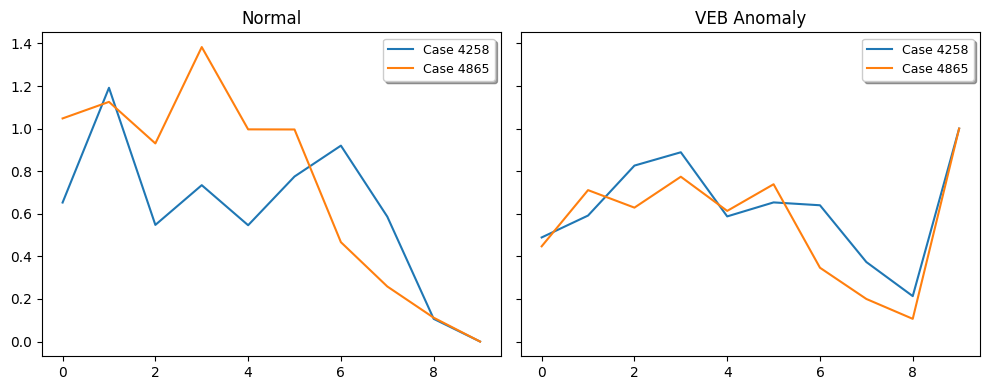

In [12]:
groupby_df = df.groupby("label")
normal_df = groupby_df.get_group(0)
anomaly_df = groupby_df.get_group(1)

plot_sample(normal_df, anomaly_df)

In [10]:
print("The Shape of Normal Beat is ",normal_df.shape)
print("The Shape of VEB Beat is ",anomaly_df.shape)

The Shape of Normal Beat is  (6814, 10)
The Shape of VEB Beat is  (6612, 10)


The lebel column have two different types classification one is Normal beat and another one is VEB anomaly beat.

The shape of the Normal beat dataset is (6814, 10) and shape of the VEB anomaly beat dataset is (6612, 10).

## Smoothed Mean Plot for Class Comparison

In this Python code, a function called `plot_smoothed_mean` is defined for creating smoothed mean plots. It takes input data, a class name, and a step size as parameters. The function calculates the rolling mean and standard deviation of the data with the specified step size, then plots the smoothed mean along with a shaded area representing the margin of three times the standard deviation.

The code also demonstrates the use of this function to compare the smoothed means of different classes. It creates a subplot with two panels, each representing a different class. The data for each class is grouped, and the mean is computed before passing it to the `plot_smoothed_mean` function. This allows for visualizing how the smoothed means of different classes compare.

The resulting plot provides insights into how the means of different classes vary over time or some other variable represented by the data, with shaded areas indicating the uncertainty around the mean estimates.


In [11]:
def plot_smoothed_mean(data, class_name = "normal", step_size=5, ax=None):
    df = pd.DataFrame(data)
    roll_df = df.rolling(step_size)
    smoothed_mean = roll_df.mean().dropna().reset_index(drop=True)
    smoothed_std = roll_df.std().dropna().reset_index(drop=True)
    margin = 3*smoothed_std
    lower_bound = (smoothed_mean - margin).values.flatten()
    upper_bound = (smoothed_mean + margin).values.flatten()

    ax.plot(smoothed_mean.index, smoothed_mean)
    ax.fill_between(smoothed_mean.index, lower_bound, y2=upper_bound, alpha=0.3, color="red")
    ax.set_title(class_name, fontsize=9)

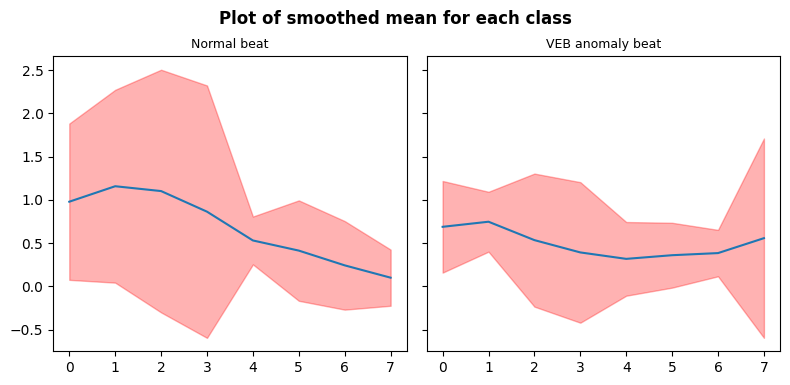

In [12]:
CLASS_NAMES = ["Normal beat", "VEB anomaly beat"]


fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
axes = axes.flatten()
for i, label in enumerate(CLASS_NAMES, start=1):
    data_group = df.groupby("label")
    data = data_group.get_group(i-1).mean(axis=0, numeric_only=True).to_numpy()
    plot_smoothed_mean(data, class_name=label, step_size=3, ax=axes[i-1])
fig.suptitle("Plot of smoothed mean for each class", y=0.95, weight="bold")
plt.tight_layout()

## Heatmap of the correlation between the features 

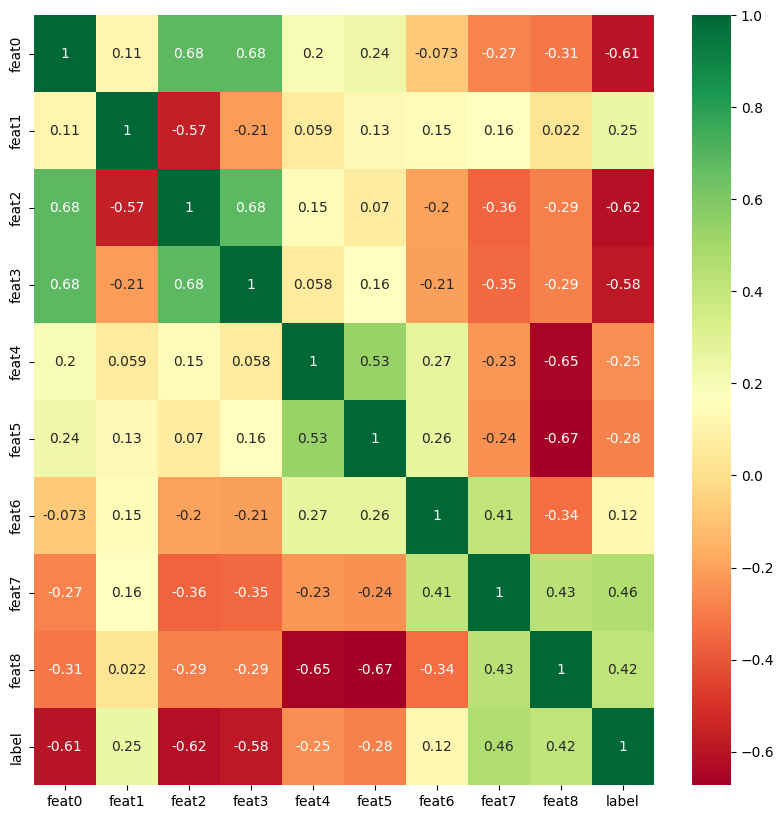

In [13]:
#get correlations of each features in dataset
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### Remove Data from Dataset

Now we can make a copy of `df`(ECG dataset). 

In [14]:
df_null = df.copy()

The work of this below code `df.isnull().sum().sum()` is to find the total sum of Null values in the ECG dataset

In [15]:
df_null.shape

(13426, 10)

In [16]:
df_null.isnull().sum().sum()

0

The above code tell us that the dataset not contain any null values.

But without null values, how can we perform Data cleaning process and show that the Data Pre-Processing step is important.

To show the Data Pre-Processing step we remove some value manually from this dataset.

The below code choose one row index and one column index randomly and replace the value with null value.

In [17]:
for i in range(1,10000):
    try:
        random_row_index = np.random.choice(df_null.index)
        random_column_index = np.random.choice(range(0,8))
        df_null.iloc[random_row_index, random_column_index] = np.nan
    except:
        continue

In [18]:
df_null.isnull().sum().sum()

9512

In [19]:
df_null.sample(5)

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,label
7089,0.502778,NaN,0.368635,0.957672,NaN,0.584971,0.493333,0.360000,0.226667,1
723,0.766667,0.625926,1.227879,1.912451,0.970175,0.987918,NaN,0.213333,0.093333,0
7795,0.519444,1.372222,0.378543,0.593651,0.605651,0.619409,0.506667,0.400000,0.186667,1
8783,0.569444,0.836111,0.681063,0.650794,-0.759846,-0.725411,0.200000,0.386667,0.813333,1
695,0.725445,0.524000,1.384137,1.990083,0.549531,0.970994,0.875200,0.135466,0.053333,0


# Without Data Cleanning

Here we replace the null values with a constant value 9.

In [20]:
# df.replace(np.nan,1000,inplace=True)
# df.dropna(inplace=True)
df1 = df_null.copy()
df1.fillna(9,inplace=True)

In [21]:
df1.isnull().sum().sum()

0

In [22]:
df1.shape

(13426, 10)

Now we divide the ECG dataset into input and output section. 
This `X` is input and `y` is output section.

In [23]:
X = df1.drop(columns=['label'])
y = df1['label']

In [24]:
X.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8
0,0.181945,0.788889,0.229457,1.000000,1.000000,1.000000,0.206667,0.120000,0.050000
1,0.401389,0.900463,0.446043,9.000000,0.980533,0.974962,0.411111,0.227778,0.086667
2,0.412106,0.625663,0.659932,1.134788,0.947328,0.980014,0.324776,0.180099,0.081592
3,0.420371,0.773148,0.543274,1.367506,0.860556,9.000000,0.271111,0.186667,0.097778
4,0.377778,0.597222,0.632558,1.247706,0.982752,0.968345,0.293333,0.146667,0.066667


In [25]:
y.sample(10)

12593    1
10044    1
3815     0
9707     1
2259     0
5220     0
3021     0
7528     1
10328    1
4542     0
Name: label, dtype: int64

Now we devide this independent `X` and dependent `y` in train and test data.

To divide into train and test data, we use `train_test_split` library.

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

## Model Evaluation

### 1. Decision Tree

In [27]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)
accuracy_score(y_test,y_pred)

0.934763181411975

In [28]:
# accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.934763181411975
Recall: 0.9373881932021467
Precision: 0.9323843416370107
Confusion Matrix:
 [[1566  114]
 [ 105 1572]]
F1 Score: 0.9348795718108832
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.93      1680
           1       0.93      0.94      0.93      1677

    accuracy                           0.93      3357
   macro avg       0.93      0.93      0.93      3357
weighted avg       0.93      0.93      0.93      3357



### 2.Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.9645516830503426

In [30]:
# accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.9645516830503426
Recall: 0.962432915921288
Precision: 0.9664670658682635
Confusion Matrix:
 [[1624   56]
 [  63 1614]]
F1 Score: 0.964445772333433
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96      1680
           1       0.97      0.96      0.96      1677

    accuracy                           0.96      3357
   macro avg       0.96      0.96      0.96      3357
weighted avg       0.96      0.96      0.96      3357



### 3. XGBoost

In [31]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
accuracy_score(y_test,y_pred)

0.9728924635090855

In [32]:
# accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.9728924635090855
Recall: 0.9719737626714371
Precision: 0.973715651135006
Confusion Matrix:
 [[1636   44]
 [  47 1630]]
F1 Score: 0.9728439271859147
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1680
           1       0.97      0.97      0.97      1677

    accuracy                           0.97      3357
   macro avg       0.97      0.97      0.97      3357
weighted avg       0.97      0.97      0.97      3357



Here the Decision tree gives **94.01%** accuracy, Random Forest gives **96.9%** accuracy and XGBoost gives **97.43%** accuracy.

So here **XGBoost** model gives us best accuracy score.

# Data Cleanning

## 1. Remove Rows

In this method when we find any row which one have null values then we remove the row from the dataset.

In [33]:
df2 = df_null.copy()

In [34]:
df2.isnull().sum().sum()

9512

In [35]:
df2.shape

(13426, 10)

To remove null value contain rows we have use `df2.dropna(inplace=True)` code.

In [36]:
df2.dropna(inplace=True)

In [37]:
df2.isnull().sum().sum()

0

In [38]:
df2.shape

(6446, 10)

Before remove row we have total 13,426 rows but after data cleanning operation now we have total 6,333 rows.

We see that the number of rows reduce by 50%. So the amount of data is reduce, for that we are not use this technique very much.

In [39]:
X = df2.drop(columns=['label'])
y = df2['label']

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

# Model Evaluation

### 1. Decision Tree

In [41]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)
accuracy_score(y_test,y_pred)

0.9578163771712159

In [42]:
# accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.9578163771712159
Recall: 0.952088452088452
Precision: 0.9639303482587065
Confusion Matrix:
 [[769  29]
 [ 39 775]]
F1 Score: 0.9579728059332508
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       798
           1       0.96      0.95      0.96       814

    accuracy                           0.96      1612
   macro avg       0.96      0.96      0.96      1612
weighted avg       0.96      0.96      0.96      1612



### 2.Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.9739454094292804

In [44]:
# accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.9739454094292804
Recall: 0.972972972972973
Precision: 0.9753694581280788
Confusion Matrix:
 [[778  20]
 [ 22 792]]
F1 Score: 0.974169741697417
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       798
           1       0.98      0.97      0.97       814

    accuracy                           0.97      1612
   macro avg       0.97      0.97      0.97      1612
weighted avg       0.97      0.97      0.97      1612



### 3. XGBoost

In [45]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
accuracy_score(y_test,y_pred)

0.9727047146401985

In [46]:
# accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.9727047146401985
Recall: 0.9778869778869779
Precision: 0.9683698296836983
Confusion Matrix:
 [[772  26]
 [ 18 796]]
F1 Score: 0.9731051344743277
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       798
           1       0.97      0.98      0.97       814

    accuracy                           0.97      1612
   macro avg       0.97      0.97      0.97      1612
weighted avg       0.97      0.97      0.97      1612



Here the Decision tree gives **94.86%** accuracy, Random Forest gives **97.18%** accuracy and XGBoost gives **97.68%** accuracy.

So here **XGBoost** model gives us best accuracy score.

## 2. Univariate Imputation

In this Univariate Imputation using `mean()` , `median()` , `mode()` we fill the null values and remove the null values from dataset.

The best advantage of this technique is here the number of row not reduce means the shape of dataset in constant.

In [47]:
df3 = df_null.copy()

In [48]:
df3.isnull().sum().sum()

9512

To fill the null values here we use the mean imputation technique.

To use mean imputation we use `df3[column_name].mean()` code.

In [49]:
clm = df3.columns

for i,feat in enumerate(clm):
    df3[feat].fillna(df3[feat].mean(), inplace=True)

In [50]:
df3.isnull().sum().sum()

0

In [51]:
df3.shape

(13426, 10)

In [52]:
X = df3.drop(columns=['label'])
y = df3['label']

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

# Model Evaluation

### 1. Decision Tree

In [54]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)
accuracy_score(y_test,y_pred)

0.94489127196902

In [55]:
# accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.94489127196902
Recall: 0.9421145894861194
Precision: 0.9482758620689655
Confusion Matrix:
 [[1577   87]
 [  98 1595]]
F1 Score: 0.9451851851851852
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94      1664
           1       0.95      0.94      0.95      1693

    accuracy                           0.94      3357
   macro avg       0.94      0.94      0.94      3357
weighted avg       0.94      0.94      0.94      3357



### 2. Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.9702114983616325

In [57]:
# accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.9702114983616325
Recall: 0.96751329001772
Precision: 0.9732620320855615
Confusion Matrix:
 [[1619   45]
 [  55 1638]]
F1 Score: 0.9703791469194313
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1664
           1       0.97      0.97      0.97      1693

    accuracy                           0.97      3357
   macro avg       0.97      0.97      0.97      3357
weighted avg       0.97      0.97      0.97      3357



### 3. XGBoost

In [58]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
accuracy_score(y_test,y_pred)

0.9740840035746202

In [59]:
# accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.9740840035746202
Recall: 0.9757826343768459
Precision: 0.9729093050647821
Confusion Matrix:
 [[1618   46]
 [  41 1652]]
F1 Score: 0.9743438513712769
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      1664
           1       0.97      0.98      0.97      1693

    accuracy                           0.97      3357
   macro avg       0.97      0.97      0.97      3357
weighted avg       0.97      0.97      0.97      3357



Here the Decision tree gives **95.11%** accuracy, Random Forest gives **97.31%** accuracy and XGBoost gives **97.52%** accuracy.

So here **XGBoost** model gives us best accuracy score.

## 3. Multivariate Imputation 

For this Multivariate Imputation technique we use KNNImputer that can fill the null values.

In [60]:
df4 = df_null.copy()

In [61]:
df4.isnull().sum().sum()

9512

To remove null values first we import the KNNImputer module using `from sklearn.impute import KNNImputer` code.

In [62]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
df4 = imputer.fit_transform(df4)

In [63]:
df4 = pd.DataFrame(df4)
df4.isnull().sum().sum()

0

In [64]:
df4.head()

,0,1,2,3,4,5,6,7,8,9
0,0.181945,0.788889,0.229457,1.000000,1.000000,1.000000,0.206667,0.120000,0.050000,0.0
1,0.401389,0.900463,0.446043,0.973587,0.980533,0.974962,0.411111,0.227778,0.086667,0.0
2,0.412106,0.625663,0.659932,1.134788,0.947328,0.980014,0.324776,0.180099,0.081592,0.0
3,0.420371,0.773148,0.543274,1.367506,0.860556,0.976484,0.271111,0.186667,0.097778,0.0
4,0.377778,0.597222,0.632558,1.247706,0.982752,0.968345,0.293333,0.146667,0.066667,0.0


Now in the dataset no null value is present.

For use the KNNImputer the column name have change.

In [65]:
X = df4.iloc[:,0:9]
y = df4.iloc[:,-1]

In [66]:
X.head()

,0,1,2,3,4,5,6,7,8
0,0.181945,0.788889,0.229457,1.000000,1.000000,1.000000,0.206667,0.120000,0.050000
1,0.401389,0.900463,0.446043,0.973587,0.980533,0.974962,0.411111,0.227778,0.086667
2,0.412106,0.625663,0.659932,1.134788,0.947328,0.980014,0.324776,0.180099,0.081592
3,0.420371,0.773148,0.543274,1.367506,0.860556,0.976484,0.271111,0.186667,0.097778
4,0.377778,0.597222,0.632558,1.247706,0.982752,0.968345,0.293333,0.146667,0.066667


In [67]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: 9, dtype: float64

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

# Model Evaluation

### 1. Decision Tree

In [69]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)
accuracy_score(y_test,y_pred)

0.9615728328865059

In [70]:
# accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.9615728328865059
Recall: 0.9697153240460327
Precision: 0.9529761904761904
Confusion Matrix:
 [[1627   79]
 [  50 1601]]
F1 Score: 0.9612728910237166
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      1706
         1.0       0.95      0.97      0.96      1651

    accuracy                           0.96      3357
   macro avg       0.96      0.96      0.96      3357
weighted avg       0.96      0.96      0.96      3357



### 2. Random Forest

In [71]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.9803395889186773

In [72]:
# accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.9803395889186773
Recall: 0.9794064203513022
Precision: 0.9805942995755003
Confusion Matrix:
 [[1674   32]
 [  34 1617]]
F1 Score: 0.9799999999999999
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      1706
         1.0       0.98      0.98      0.98      1651

    accuracy                           0.98      3357
   macro avg       0.98      0.98      0.98      3357
weighted avg       0.98      0.98      0.98      3357



### 3. XGBoost

In [73]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
accuracy_score(y_test,y_pred)

0.9785522788203753

In [74]:
# accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Accuracy: 0.9785522788203753
Recall: 0.9800121138703816
Precision: 0.9764634882317441
Confusion Matrix:
 [[1667   39]
 [  33 1618]]
F1 Score: 0.9782345828295043
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      1706
         1.0       0.98      0.98      0.98      1651

    accuracy                           0.98      3357
   macro avg       0.98      0.98      0.98      3357
weighted avg       0.98      0.98      0.98      3357



Here the Decision tree gives **96.3%** accuracy, Random Forest gives **98%** accuracy and XGBoost gives **98.24%** accuracy.

So here **XGBoost** model gives us best accuracy score.

# Conclusion 

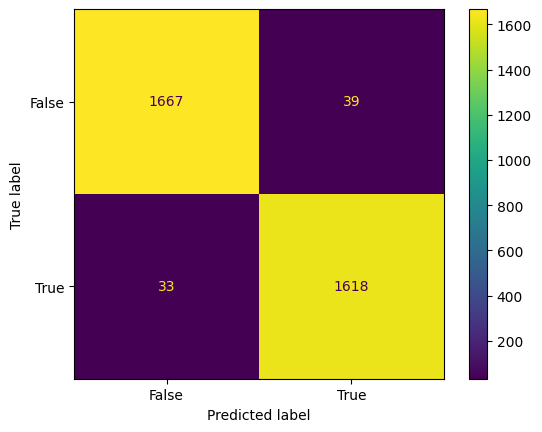

In [75]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test,y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

This above confusion matrix show the best model among all of this. This is **XGBoost** with **KNNImputer**.

In this below table you see the all accurey score of all models (Decision Tree, Random Forest, XGBoost) in different kind Data Pre-Processing.



|     | Decision Tree | Random Forest | XGBoost |
| :---------- | :------------- | :------------ | :------------ |
| **Without Data Cleaning** | 94.01% | 96.9% | 97.43% |
| **Remove the Rows** | 94.86% | 97.18% | 97.68% |
| **Univariate Imputation** | 95.11% | 97.31% | 97.52% |
| **Multivariate Imputation** | 96.3% | 98% | 98.24% |

Till now we have see the **KNNImputer** and **XGBoost** together gives the best output result.

Now we see the Features Important in ECG Dataset.

# Features Engineering 

In `df4` dataset we perform the KNNImputer for Data cleaning the we have used the **XGBoost** algorithm and this give the best result. So now we will use `df4` dataset to check whether the feature engineering gives the best, same, or worse result

In [76]:
df4.isnull().sum().sum()

0

In [77]:
df4.shape

(13426, 10)

In [78]:
df4.head()

,0,1,2,3,4,5,6,7,8,9
0,0.181945,0.788889,0.229457,1.000000,1.000000,1.000000,0.206667,0.120000,0.050000,0.0
1,0.401389,0.900463,0.446043,0.973587,0.980533,0.974962,0.411111,0.227778,0.086667,0.0
2,0.412106,0.625663,0.659932,1.134788,0.947328,0.980014,0.324776,0.180099,0.081592,0.0
3,0.420371,0.773148,0.543274,1.367506,0.860556,0.976484,0.271111,0.186667,0.097778,0.0
4,0.377778,0.597222,0.632558,1.247706,0.982752,0.968345,0.293333,0.146667,0.066667,0.0


In [79]:
df4.columns

RangeIndex(start=0, stop=10, step=1)

First we will extract the features from `df4` dataset using `features = df4.drop(columns=[9])` code.

In [80]:
features = df4.drop(columns=[9])

In [81]:
features.head()

,0,1,2,3,4,5,6,7,8
0,0.181945,0.788889,0.229457,1.000000,1.000000,1.000000,0.206667,0.120000,0.050000
1,0.401389,0.900463,0.446043,0.973587,0.980533,0.974962,0.411111,0.227778,0.086667
2,0.412106,0.625663,0.659932,1.134788,0.947328,0.980014,0.324776,0.180099,0.081592
3,0.420371,0.773148,0.543274,1.367506,0.860556,0.976484,0.271111,0.186667,0.097778
4,0.377778,0.597222,0.632558,1.247706,0.982752,0.968345,0.293333,0.146667,0.066667


In [82]:
label = df4[9]

In [83]:
label.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: 9, dtype: float64

Now we have one `features` dataset where all the input column is present and second `label` dataset where the output column is present.

Now we will analysis which feature is more important to predict the output in the dataset and then the plot a graph to see the features important.

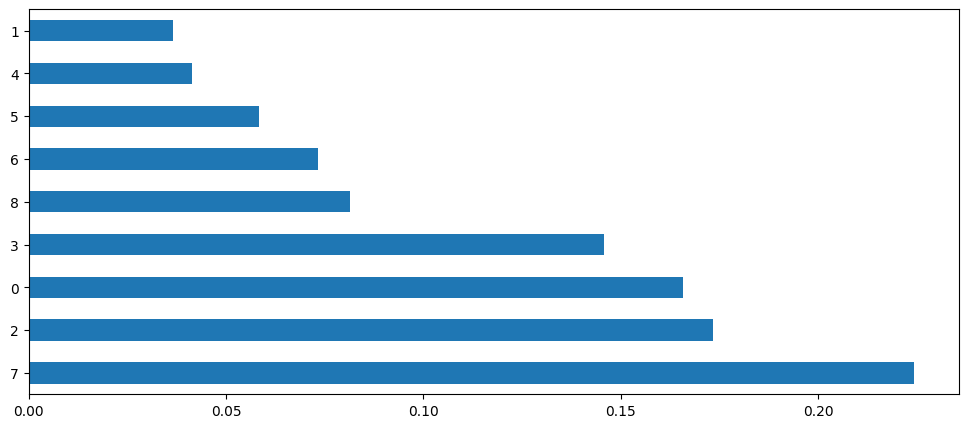

In [84]:
plt.figure(figsize=(12,5))
from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor()
etr.fit(features, label)
feature_importance = pd.Series(etr.feature_importances_, index=features.columns)
feature_importance.nlargest(20).plot(kind='barh')
plt.show()

Where we see that the feature **7**, **0** and **2** is more important to predict the output and then feature **3**, **8** and the last least important feature is **6**, **5**, **4** and **1**.

In [85]:
features_important_index = list(feature_importance.sort_values(ascending=False).index)
features_important_index

[7, 2, 0, 3, 8, 6, 5, 4, 1]

Here we will create a list of most important features.

Now we will the the accurecy of the model with using the different features.

In [86]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

X_features = []
y_features = [9]
for i,feat in enumerate(features_important_index):
    X_features.append(feat)
    X = df4.iloc[:,X_features]
    y = df4.iloc[:,y_features]
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
    
    xgb = XGBClassifier()
    xgb.fit(X_train,y_train)
    y_pred = xgb.predict(X_test)
    acc_score = accuracy_score(y_test,y_pred)
    
    print(f"The Accuracy score is {acc_score*100} using {i+1} features that are {X_features}")

The Accuracy score is 84.71849865951742 using 1 features that are [7]
The Accuracy score is 90.55704498063747 using 2 features that are [7, 2]
The Accuracy score is 94.51891569854037 using 3 features that are [7, 2, 0]
The Accuracy score is 96.54453380994936 using 4 features that are [7, 2, 0, 3]
The Accuracy score is 97.6169198689306 using 5 features that are [7, 2, 0, 3, 8]
The Accuracy score is 97.31903485254692 using 6 features that are [7, 2, 0, 3, 8, 6]
The Accuracy score is 97.8850163836759 using 7 features that are [7, 2, 0, 3, 8, 6, 5]
The Accuracy score is 98.21268990169794 using 8 features that are [7, 2, 0, 3, 8, 6, 5, 4]
The Accuracy score is 98.2424784033363 using 9 features that are [7, 2, 0, 3, 8, 6, 5, 4, 1]


This above code give us the accuracy score on different features.

| Total Number Features | Name of the Features Columns | Accuracy Score |
| --------------------- | ---------------------------- | -------------- |
| 1 | [7] | 83.16% |
| 2 | [7, 0] | 91.33% |
| 3 | [7, 0, 2] | 95.26% |
| 4 | [7, 0, 2, 3] | 96.03% |
| 5 | [7, 0, 2, 3, 8] | 97.49% |
| 6 | [7, 0, 2, 3, 8, 6] | 97.55% |
| 7 | [7, 0, 2, 3, 8, 6, 5] | 98.27% |
| 8 | [7, 0, 2, 3, 8, 6, 5, 4] | 98.18% |
| 9 | [7, 0, 2, 3, 8, 6, 5, 4, 1] | 98.18% |

From the above table we see that with 7 features the model gives us the best accuracy score instead of using 9 features.
So for our final model we use [0, 2, 3, 5, 6, 7, 8] features.